# Libs

In [1]:
import math
import warnings

import numpy as np
import arviz as az
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scipy.special as sc
import theano.tensor as tt
import matplotlib.pyplot as plt
from scipy import stats
#from theano import shared, function
#from pymc3.distributions.dist_math import betaln, bound

from custom import pert

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on PyMC v3.11.4
Running on ArviZ v0.11.2


# Main

## Pure Players

### Last Mile Package (Single Cell)

#### Model

In [69]:
with pm.Model() as model:
    pp_bs = pert(name="Pure Players Basket Size", a=1, b=2, c=5, transform=None) # basket size distribution for pure players
    pp_product_volume = pm.Lognormal(name='Product Weight', mu=-1.38, sigma=1.14) # volume of product in liters (l)
    pp_box_saturation = pert(name='Box Saturation', a=.1, b=.5, c=.9, transform=None) # share of box volume consumed by product (l/l)
    pp_waste_ghg = pm.Bernoulli(name='Waste GHG', p=.21)*0.15 # GHG of cardboard disposal (either 0 or 0.15)
    
    pp_cardboard_weight = 12.5 # grams of cardboard per every liter of box volume (g/l)
    pp_cardboard_ghg = .001 # kg GHG per g of cardboard (kg/g)
    pp_lm_cardboard = pm.Deterministic(name='PP LM Cardboard Weight', var=pp_cardboard_weight * pp_product_volume / pp_box_saturation) # distribution of weights of cardbord per single package (g)

    pp_cardboard_total_ghg = pm.Deterministic(name='PP Cardboard GHG', var=pp_lm_cardboard * (pp_cardboard_ghg + pp_waste_ghg))

    pp_paper_weight = .033 # grams of paper per every liter of void volume (g/l)
    pp_paper_ghg = .0012 # kg GHG per g of paper (kg/g)
    pp_lm_paper = pm.Deterministic(name='PP LM Paper Weight', var=pp_paper_weight * pp_product_volume * (1 - pp_box_saturation))

    pp_paper_total_ghg = pm.Deterministic(name='PP Paper GHG', var=pp_lm_paper * (pp_paper_ghg + pp_waste_ghg))
    
    pp_package_total_ghg = pm.Deterministic(name='PP Package GHG', var=pp_cardboard_total_ghg+pp_paper_total_ghg)
    pp_package_total_ghg
    
    data = pm.sample(2000, tune=1500)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [Box Saturation, Product Weight, Pure Players Basket Size]
>BinaryGibbsMetropolis: [Waste GHG]


/Applications/anaconda3/envs/pymcenv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Applications/anaconda3/envs/pymcenv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Applications/anaconda3/envs/pymcenv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Applications/anaconda3/envs/pymcenv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 23 seconds.
There were 394 divergences after tuning. Increase `target_accept` or reparameterize.
There were 361 divergences after tuning. Increase `targ

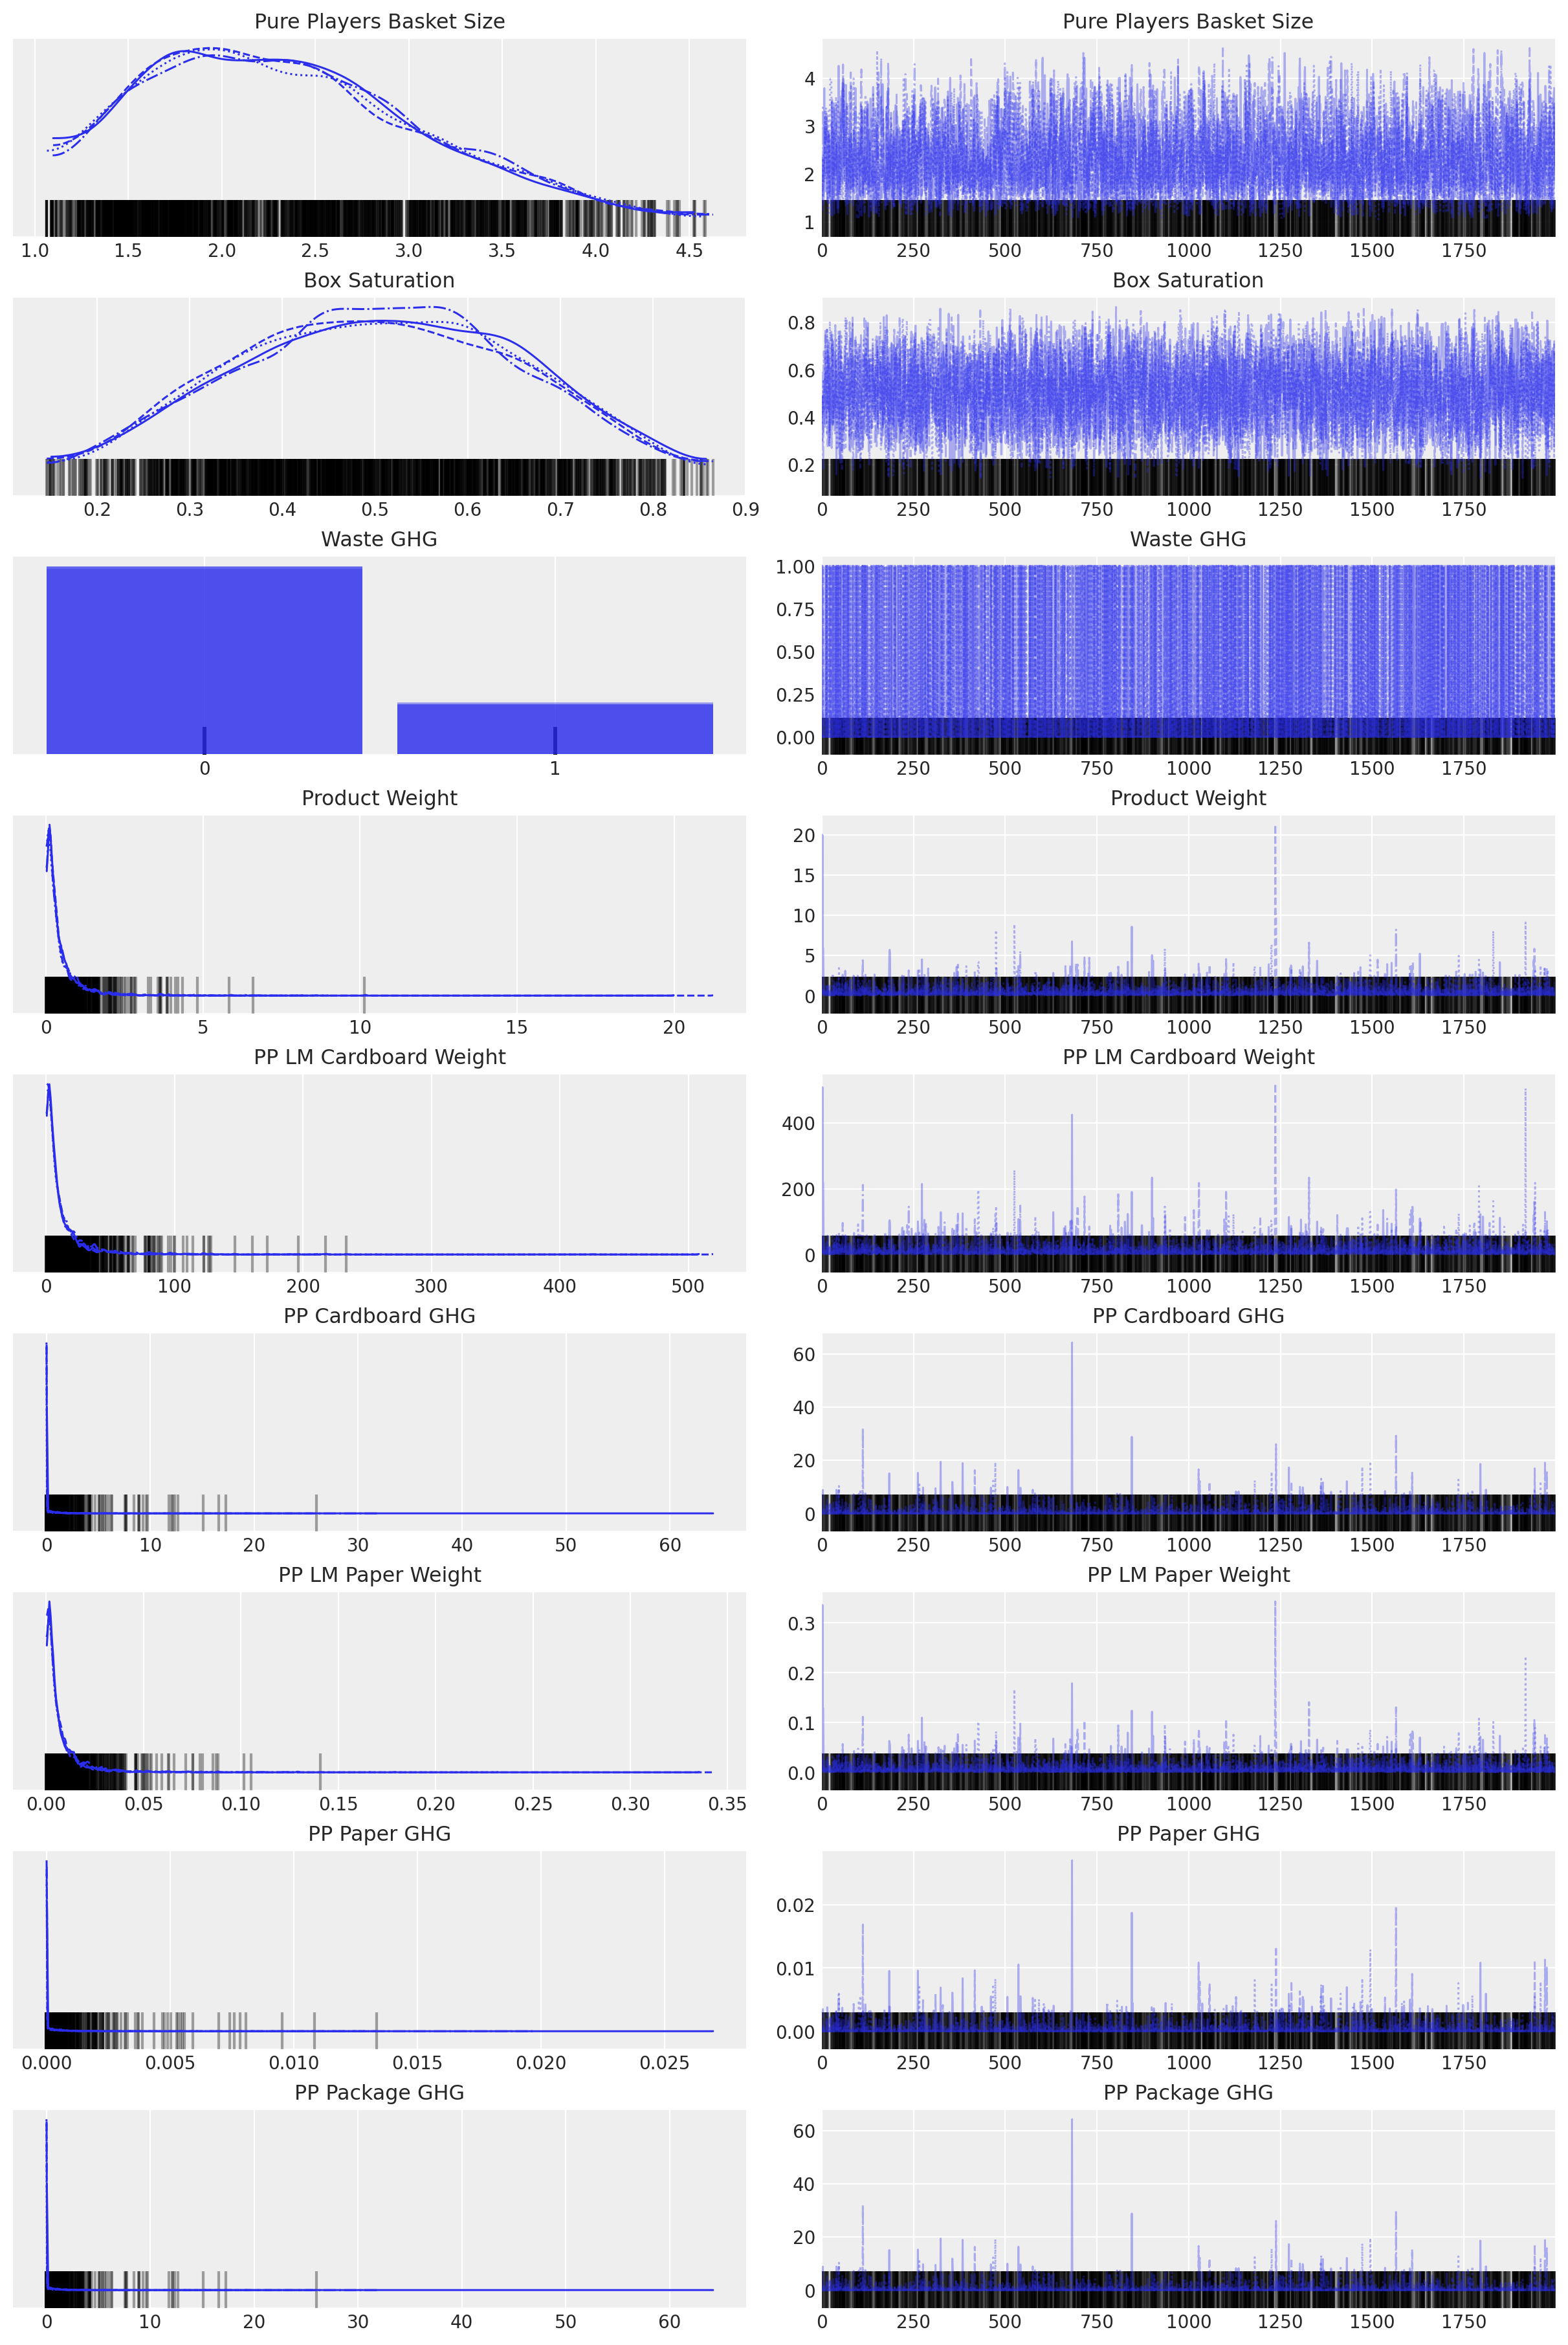

In [71]:
az.plot_trace(data);

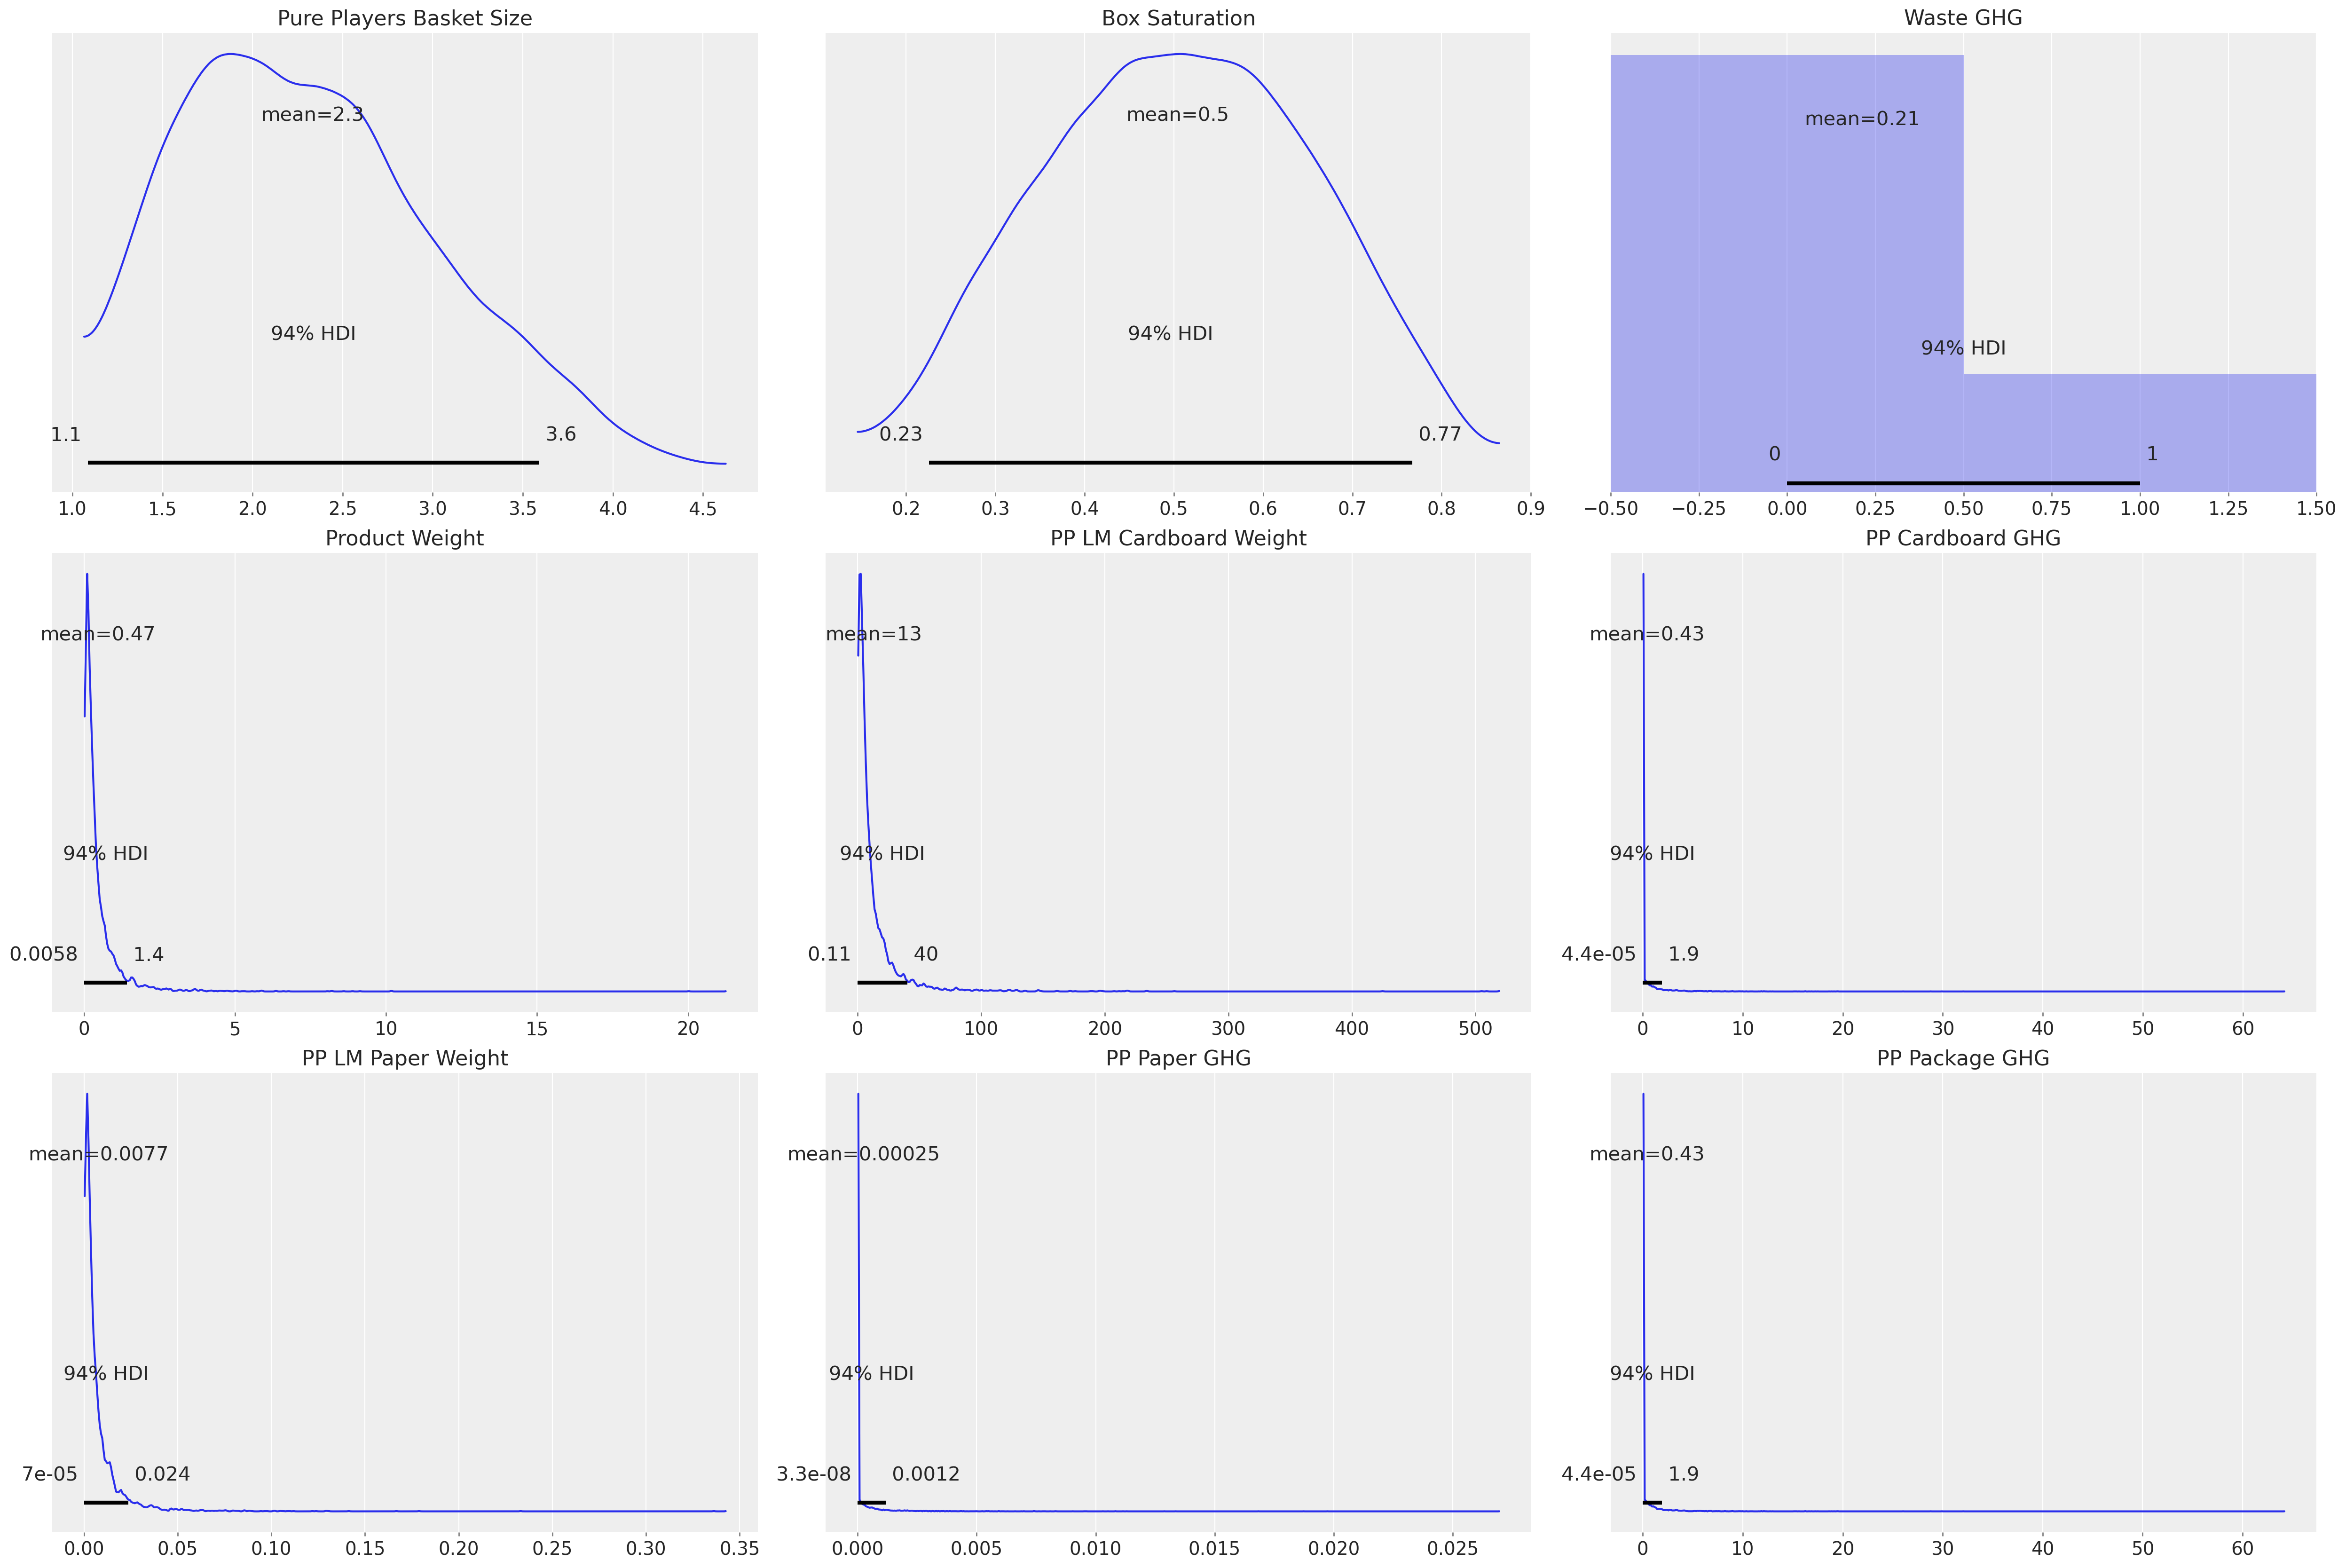

In [ ]:
az.plot_posterior(data);

### Last Mile Packaging (Multiple Cells)

In [46]:
with pm.Model() as model:
    pp_bs = pert(name="Pure Players Basket Size", a=1, b=2, c=5, transform=None) # basket size distribution for pure players
    pp_product_volume = pm.Lognormal(name='Product Weight', mu=-1.38, sigma=1.14) # volume of product in liters (l)
    pp_box_saturation = pert(name='Box Saturation', a=.1, b=.5, c=.9, transform=None) # share of box volume consumed by product (l/l)
    pp_waste_ghg = pm.Bernoulli(name='Waste GHG', p=.21)*0.15 # GHG of cardboard disposal (either 0 or 0.15)

#### Cardboard Box

In [47]:
with pm.Model() as model:
    pp_cardboard_weight = 12.5 # grams of cardboard per every liter of box volume (g/l)
    pp_cardboard_ghg = .001 # kg GHG per g of cardboard (kg/g)
    pp_lm_cardboard = pm.Deterministic(name='PP LM Cardboard Weight', var=pp_cardboard_weight * pp_product_volume / pp_box_saturation) # distribution of weights of cardbord per single package (g)

    pp_cardboard_total_ghg = pm.Deterministic(name='PP Cardboard GHG', var=pp_lm_cardboard * (pp_cardboard_ghg + pp_waste_ghg))


#### Kraft Paper

In [48]:
with pm.Model() as model:
    pp_paper_weight = .033 # grams of paper per every liter of void volume (g/l)
    pp_paper_ghg = .0012 # kg GHG per g of paper (kg/g)
    pp_lm_paper = pm.Deterministic(name='PP LM Paper Weight', var=pp_paper_weight * pp_product_volume * (1 - pp_box_saturation))

    pp_paper_total_ghg = pm.Deterministic(name='PP Paper GHG', var=pp_lm_paper * (pp_paper_ghg + pp_waste_ghg))

#### Total Package GHG

In [51]:
with pm.Model() as model:
    pp_package_total_ghg = pm.Deterministic(name='PP Package GHG', var=pp_cardboard_total_ghg+pp_paper_total_ghg)
    model.free_RVs

## Bricks & Clicks

In [3]:
with pm.Model():
    bc_bs = pert(name="Bricks & Clicks Basket Size", a=5, b=45, c=100, transform=None) # basket size distribution for bricks & clicks

## Passenger Car

In [20]:
car_milage = 2400000 # avg passenger car milage (km)
car_weight = 1000 # avg passenger car weight in (kg)

car_maint = 1080 # GHG per car caused by maintenance (kg)
car_maint_ghg = car_maint / car_milage # GHG per every km caused by maintenance (kg/km)

car_emis = 7 # GHG per kg of car weight caused by direct emissions (kg/kg)
car_emis_ghg = car_emis * car_weight / car_milage # GHG per every km caused by direct emissions (kg/km)

car_total_ghg = car_maint_ghg + car_emis_ghg